<h1>Deep Learning and Transfer Learning with pre-trained models<h1>

In [1]:
# import reqired libs
import os
import keras
import numpy as np
from keras import backend as k
from keras import applications
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

%matplotlib inline

<h3>Load VGG</h3>

In [5]:
vgg_model = applications.VGG19(include_top=False, weights='imagenet')

2023-02-25 14:15:03.023713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 14:15:03.023738: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 14:15:03.023755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-02-25 14:15:03.024182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


80134624/80134624 [==============================] - 44s 1us/step


In [6]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [7]:
# Set Parameters
batch_size = 128
num_classes = 10
epochs = 50

bottleneck_path = r'F:\work\kaggle\cifar10_cnn\bottleneck_features_train_vgg19.npy'

<h3>Get CIFAR10 Dataset</h3>

In [8]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
# Convert class vectors to binary class matrix
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train.shape

(50000, 10)

<h3>Pretrained Model for Featire Extraction</h3>

In [12]:
if not os.path.exists(bottleneck_path):
    bottleneck_features_train = vgg_model.predict(x_train, verbose=1)
    np.save(open(bottleneck_path, 'wb'),
           bottleneck_features_train)
else:
    bottleneck_features_train[0].shape

1563/1563 [==============================] - 245s 156ms/step


In [13]:
bottleneck_features_train[0].shape

(1, 1, 512)

In [16]:
bottleneck_features_test = vgg_model.predict(x_test, verbose=1)

313/313 [==============================] - 47s 149ms/step


<h3>Custom Classifier</h3>

In [19]:
clf_model = Sequential()
clf_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
clf_model.add(Dense(512, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(512, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))

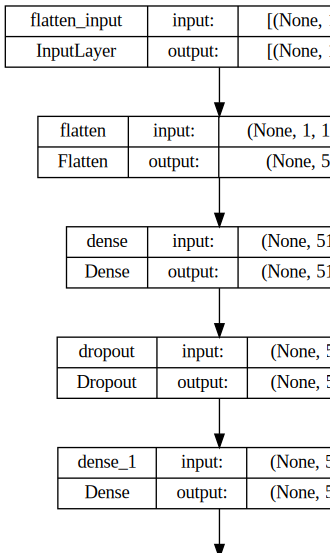

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(clf_model, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

<h3>Compile the model</h3>

In [21]:
clf_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

<h3>Train the classifier</h3>

In [22]:
clf_model.fit(bottleneck_features_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/50
391/391 [==============================] - 2s 5ms/step - loss: 30.1649 - accuracy: 0.1053
Epoch 2/50
391/391 [==============================] - 2s 5ms/step - loss: 28.4651 - accuracy: 0.1088
Epoch 3/50
391/391 [==============================] - 2s 5ms/step - loss: 27.0443 - accuracy: 0.1156
Epoch 4/50
391/391 [==============================] - 2s 5ms/step - loss: 25.8180 - accuracy: 0.1210
Epoch 5/50
391/391 [==============================] - 2s 5ms/step - loss: 24.8347 - accuracy: 0.1261
Epoch 6/50
391/391 [==============================] - 2s 6ms/step - loss: 23.9454 - accuracy: 0.1277
Epoch 7/50
391/391 [==============================] - 2s 5ms/step - loss: 22.9631 - accuracy: 0.1359
Epoch 8/50
391/391 [==============================] - 2s 5ms/step - loss: 22.1002 - accuracy: 0.1422
Epoch 9/50
391/391 [==============================] - 2s 5ms/step - loss: 21.2892 - accuracy: 0.1446
Epoch 10/50
391/391 [==============================] - 2s 5ms/step - loss: 20.6527 - accura

<h3>Predict and test model performance</h3>

In [23]:
score = clf_model.evaluate(bottleneck_features_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 2.8208 - accuracy: 0.4175


In [24]:
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  2.8208189010620117
Test accuracy:  0.41749998927116394


<h3>Assign label to test image</h3>

In [34]:
def predict_label(img_idx,show_proba=True):
    plt.imshow(x_test[img_idx],aspect='auto')
    plt.title("Image to be Labeled")
    plt.show()
    
    print("Actual Class:{}".format(np.nonzero(y_test[img_idx])[0][0]))
    
    test_image =np.expand_dims(x_test[img_idx], axis=0)
    bf = vgg_model.predict(test_image,verbose=0)
    pred_label = clf_model.predict(bf,batch_size=1,verbose=0)
    
    print("Predicted Class:{}".format(max(pred_label[0]).index))
    if show_proba:
        print("Predicted Probabilities")
        print(clf_model.predict(bf))

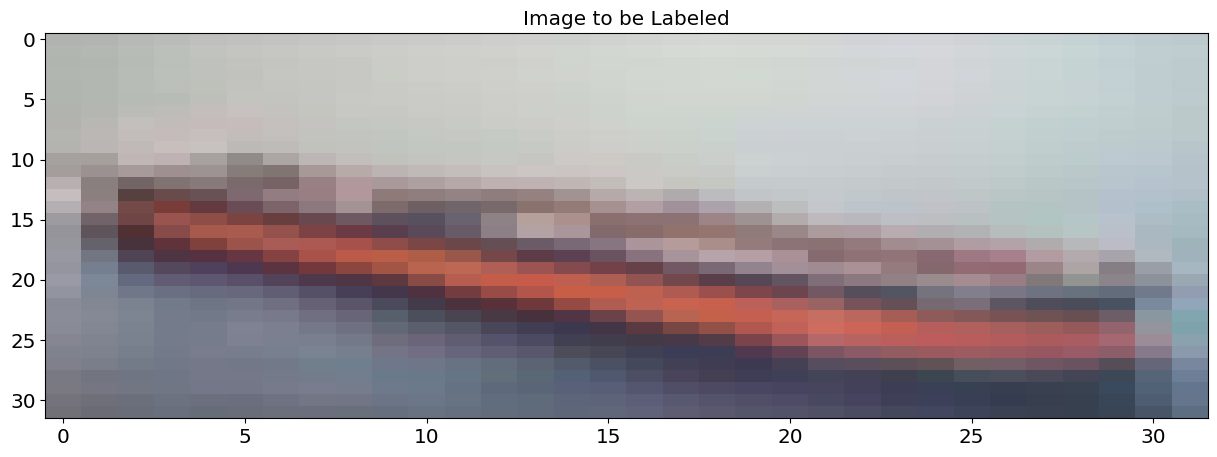

Actual Class:8


AttributeError: 'numpy.float32' object has no attribute 'index'

In [35]:
img_idx = 3999 # sample indices : 999,1999 and 3999
for img_idx in [999,1999,3999]:
    predict_label(img_idx)